In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation, PillowWriter

In [2]:
# Constants
G = 6.67430e-11  # Gravitational constant, m^3 kg^-1 s^-2
M_earth = 5.972e24  # kg
pos_earth = np.array([0, 0])
M_moon = 7.34767309e22  # kg
R_earth_moon = 3.844e8  # Average distance from Earth to Moon, m
Re = 6.371e6
Rm = 1.7374e6
moon_tan_vel = 1022
moon_angle = -np.pi/128

x0, y0 = 0, Re + 191100 
vx0, vy0 = 7800, 0
mass = 2970000 - 2300000
rocket_orbit_vel = 7800.0
rocket_angle = np.deg2rad(90-25.5)
v_rot = 465.1 * np.cos(np.deg2rad(28.5))


pos_rocket = (Re + 191100) * np.array([np.cos(rocket_angle), np.sin(rocket_angle)])
rocket_velocity = (rocket_orbit_vel+v_rot) * np.array([-np.sin(rocket_angle), np.cos(rocket_angle)])


moon_velocity = (1022-v_rot) * np.array([-np.sin(moon_angle), np.cos(moon_angle)])
pos_moon = R_earth_moon * np.array([np.cos(moon_angle), np.sin(moon_angle)])


TLI_time = 2.5 * 3600 
TLI_duration = 300
TLI_delta_v = 3050  # m/s, total velocity change needed
TLI_mass = 480000
TLI_mass_flow = TLI_mass / TLI_duration

LOI_time = 2 * 24 * 3600 + 3 * 3600 + 49 * 60 + 50 # 3:49:50
LOI_duration = 360
delta_v_LOI = 889
LOI_impulse = 314
LOI_thrust = 91000
LOI_mass_flow = LOI_thrust / LOI_impulse
LOI_mass = LOI_mass_flow * LOI_duration

LOI2_duration = 17

dt = 1.0
total_time = 500000  # Total simulation time, seconds (example)
t0 = 11 * 60 + 49
times = np.arange(t0, total_time, dt)
x, y, vx, vy = x0, y0, vx0, vy0
trajectory = []
moon_trajectory = []


class Rocket:
    def __init__(self, mass:float, pos:np.ndarray, velocity:np.ndarray) -> None:
        self.mass = mass
        self.pos = pos
        self.velocity = velocity
        self.acceleration = np.array([0,0], dtype=np.float64)
        self.SII = True
        self.SIVB = True

    def update_mass(self, dt, mdot):
        self.mass -= mdot * dt

class Planet:
    def __init__(self, mass:float, pos:np.ndarray, velocity:np.ndarray) -> None:
        self.mass = mass
        self.pos = pos
        self.velocity = velocity
        self.acceleration = np.array([0,0], dtype=np.float64)


rocket = Rocket(mass, pos_rocket, rocket_velocity)
moon = Planet(M_moon, pos_moon, moon_velocity)
earth = Planet(M_earth, pos_earth, np.array([0, 0], dtype=np.float64))


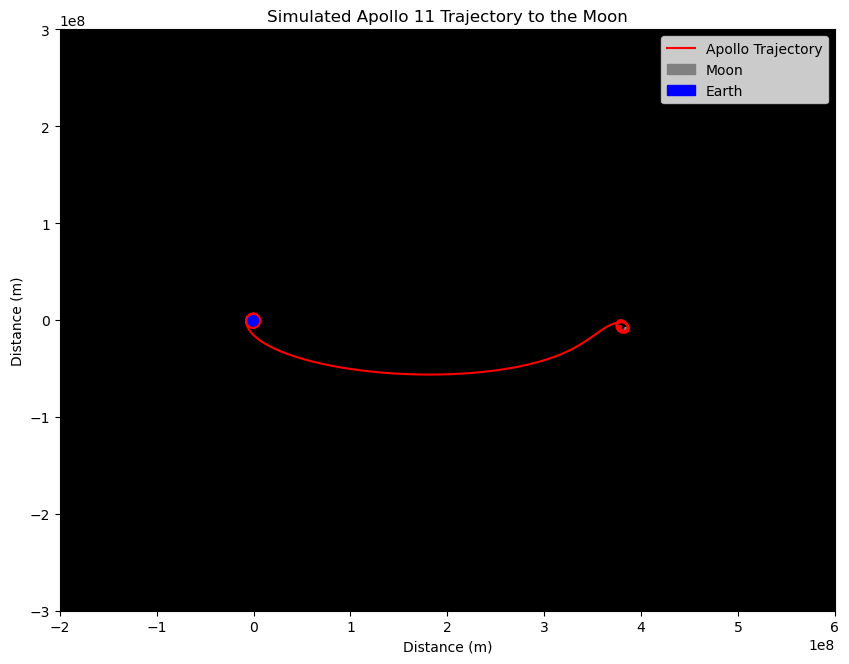

[-405.69447964  655.37938921]
[-0.52633907  0.85027477]


In [3]:
min_x, max_x = -2e8, 6e8
min_y, max_y = -3e8, 3e8

def gravity(ship_pos:np.ndarray, source_pos:np.ndarray, mass:float):
    r_vec = ship_pos - source_pos
    #r_mag = np.linalg.norm(r_vec)
    r_mag = np.sqrt(r_vec[0] ** 2 + r_vec[1] ** 2)
    return -G * mass / r_mag**2 * (r_vec/r_mag)


def get_burn(t):
    """if t < SIC_time:
        return SIC_mass_flow, SIC_impulse_sea"""
    if TLI_time <= t < TLI_time + TLI_duration: 
        TLI_impulse = TLI_delta_v / 9.81
        return TLI_mass_flow, TLI_impulse
    elif LOI_time <= t < LOI_time + LOI_duration:
        return LOI_mass_flow, LOI_impulse
    else:
        return 0, 0

def thrust_force(t, rocket:Rocket):
    direction = rocket_velocity / np.linalg.norm(rocket_velocity)
    m_dot, sp_I = get_burn(t)
    Ftx, Fty = m_dot * sp_I * direction
    return Ftx, Fty

def thrust_accel(t, rocket:Rocket):
    Ftx, Fty = thrust_force(t, rocket)
    atx, aty = Ftx/rocket.mass, Fty/rocket.mass
    return atx, aty



def gravity(ship_pos:np.ndarray, source_pos:np.ndarray, mass:float):
    r_vec = ship_pos - source_pos
    #r_mag = np.linalg.norm(r_vec)
    r_mag = np.sqrt(r_vec[0] ** 2 + r_vec[1] ** 2)
    return -G * mass / r_mag**2 * (r_vec/r_mag)

def get_accel(rocket:Rocket, moon_pos, t):
    dist_to_moon = np.linalg.norm(rocket.pos - pos_moon)
    if dist_to_moon < 1/4 * R_earth_moon:
        ax_moon, ay_moon = gravity(rocket.pos, moon_pos, M_moon)
        ax_earth, ay_earth = gravity(rocket.pos, pos_earth, M_earth)
    else:
        ax_moon, ay_moon = gravity(rocket.pos, moon_pos, M_moon)
        ax_earth, ay_earth = gravity(rocket.pos, pos_earth, M_earth)
    ax, ay = ax_moon + ax_earth, ay_moon + ay_earth
    return np.array([ax, ay])

def TLI_burn(rocket_velocity, TLI_delta_v):
    direction = rocket_velocity / np.linalg.norm(rocket_velocity)
    return rocket_velocity + direction * TLI_delta_v

def LOI_burn(rocket:Rocket, delta_v_LOI):
    direction = rocket.velocity / np.linalg.norm(rocket.velocity)
    print(direction)
    return rocket.velocity - direction * delta_v_LOI


def rk4_update(rocket:Rocket, moon_pos, dt, t):
    k1_v = get_accel(rocket, moon_pos, t) * dt
    k1_p = rocket.velocity * dt
    rocket_mid1 = Rocket(rocket.mass, rocket.pos + k1_p/2, rocket.velocity + k1_v/2)  # Assuming Rocket class has pos, velocity, mass attributes
    k2_v = get_accel(rocket_mid1, moon_pos,t) * dt
    k2_p = (rocket.velocity + k1_v/2) * dt
    rocket_mid2 = Rocket(rocket.mass, rocket.pos + k2_p/2, rocket.velocity + k2_v/2)
    k3_v = get_accel(rocket_mid2, moon_pos,t) * dt
    k3_p = (rocket.velocity + k2_v/2) * dt
    rocket_end = Rocket(rocket.mass, rocket.pos + k3_p, rocket.velocity + k3_v)
    k4_v = get_accel(rocket_end, moon_pos,t) * dt
    k4_p = (rocket.velocity + k3_v) * dt
    rocket.velocity += (k1_v + 2*k2_v + 2*k3_v + k4_v) / 6
    rocket.pos += (k1_p + 2*k2_p + 2*k3_p + k4_p) / 6


for t in times:
    if t - TLI_time == 0:   
        rocket.velocity = TLI_burn(rocket.velocity, TLI_delta_v)
        rocket.mass -= TLI_mass
    """if t == 240000:
        direction = rocket.velocity / np.linalg.norm(rocket.velocity)
        rocket.velocity -= direction * 100"""
    """if t - LOI_time == 0:
        rocket.velocity = LOI_burn(rocket, delta_v_LOI)
        rocket.mass -= LOI_mass"""
    
    x = moon.pos[0] - rocket.pos[0]
    y = moon.pos[1] - rocket.pos[1]
    if t == 380000:
        direction = rocket.velocity / np.linalg.norm(rocket.velocity)
        rocket.velocity -= direction * 300

    theta = np.arctan(y/(x+1e-9))

    
    """if t == 450000:
        rocket.velocity += np.array([200,0],dtype=np.float64)"""
    
    rk4_update(rocket, moon.pos, dt, t)
    trajectory.append(np.copy(rocket.pos))
    """moon_accel = gravity(moon.pos, earth.pos, earth.mass)
    moon.velocity += moon_accel * dt
    moon.pos += moon.velocity * dt
    moon_trajectory.append(np.copy(moon.pos))"""

    """if t % 10000 == 0:
        moon2 = Circle(pos_moon, Rm, color='grey', label="Moon")
        earth2 = Circle(pos_earth, Re, color='blue', label="Earth")
        fig, ax = plt.subplots(figsize=(10, 8))
        plt.scatter(rocket.pos[0], rocket.pos[1], 10, color='red')
        ax.set_xlim([-1e8, 5e8])
        ax.set_ylim([-4e8, 4e8])
        ax.add_patch(moon2)
        ax.add_patch(earth2)
        ax.set_title("Simulated Apollo 11 Trajectory to the Moon")
        ax.set_xlabel("Distance (m)")
        ax.set_ylabel("Distance (m)")
        ax.set_aspect('equal')
        ax.set_facecolor('black')
        ax.legend()
        plt.show()"""

x_vals, y_vals = zip(*trajectory)
#x_moon, y_moon = zip(*moon_trajectory)

moon = Circle(pos_moon, Rm, color='grey', label="Moon")
earth = Circle(pos_earth, Re, color='blue', label="Earth")
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(x_vals, y_vals, label='Apollo Trajectory', color='red')
#plt.plot(x_moon, y_moon, label='Moon Trajectory', color='grey')
plt.scatter(rocket.pos[0], rocket.pos[1], 10, color='red')
ax.set_xlim([min_x, max_x])
ax.set_ylim([min_y, max_y])
ax.add_patch(moon)
ax.add_patch(earth)
ax.set_title("Simulated Apollo 11 Trajectory to the Moon")
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Distance (m)")
ax.set_aspect('equal')
ax.set_facecolor('black')
ax.legend()
plt.show()
print(rocket.velocity)
direction = rocket.velocity / np.linalg.norm(rocket.velocity)
print(direction)





/local/jacob.schaefer/ipykernel_735331/172061090.py:22: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  plot.set_data(trajectory[i][0], trajectory[i][1])


"def init():\n    global plot\n    ax.set_facecolor('black')\n    plot = ax.scatter(trajectory[0][0], trajectory[0][1], 10, color='red', label='Saturn 5')\n    return plot#.collections\n\ndef animate(i):\n    global plot\n    #for c in plot.collections:\n    #    c.remove()  # Remove previous contour collections\n    ax.set_facecolor('black')\n    plot = ax.scatter(trajectory[i][0], trajectory[i][1], 10, color='red', label='Saturn 5')\n    return plot#.collections\n\nanim = FuncAnimation(fig, animate, init_func=init, frames=len(trajectory), blit=False)\nanim.save(f'Saturn5.gif', writer='pillow', fps=30)"

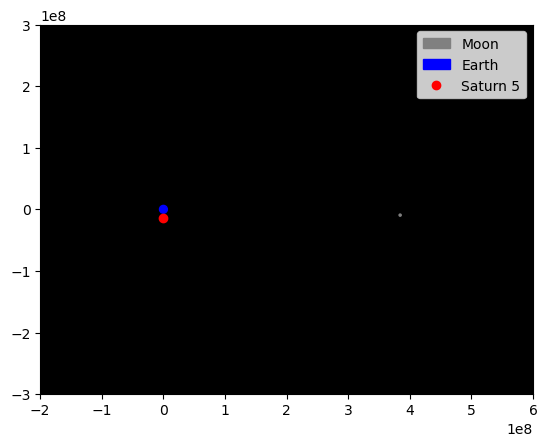

In [4]:
min_x, max_x = -2e8, 6e8
min_y, max_y = -3e8, 3e8

fig, ax = plt.subplots()
moon2 = Circle(pos_moon, Rm, color='grey', label="Moon")
earth2 = Circle(pos_earth, Re, color='blue', label="Earth")
ax.add_patch(moon2)
ax.add_patch(earth2)
#plot = ax.scatter(trajectory[0][0], trajectory[0][1], 10, color='red', label='Saturn 5')
plot, = ax.plot([], [], 'o', color='red', label='Saturn 5')
ax.set_xlim([min_x, max_x])
ax.set_ylim([min_y, max_y])
ax.set_aspect('equal')
ax.set_facecolor('black')
ax.legend()
def init():
    plot = ax.plot(trajectory[0][0], trajectory[0][1], 'o', color='red', label='Saturn 5')
    return plot, 

def animate(i):
    # Update the spacecraft's position
    plot = ax.plot(trajectory[i][0], trajectory[i][1], 'o', color='red', label='Saturn 5')
    return plot, 

anim = FuncAnimation(fig, animate, init_func=init, frames=10000, blit=True)

# Save the animation
anim.save('Saturn5.gif', writer='pillow', fps=30)
"""def init():
    global plot
    ax.set_facecolor('black')
    plot = ax.scatter(trajectory[0][0], trajectory[0][1], 10, color='red', label='Saturn 5')
    return plot#.collections

def animate(i):
    global plot
    #for c in plot.collections:
    #    c.remove()  # Remove previous contour collections
    ax.set_facecolor('black')
    plot = ax.scatter(trajectory[i][0], trajectory[i][1], 10, color='red', label='Saturn 5')
    return plot#.collections

anim = FuncAnimation(fig, animate, init_func=init, frames=len(trajectory), blit=False)
anim.save(f'Saturn5.gif', writer='pillow', fps=30)"""